## Subclassing API

사용할 패키지를 불러옵니다.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from utils import standard_scaling, R_squared, train_val_split
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

캘리포니아 집값 데이터 클래스를 불러옵니다.

In [2]:
housing = fetch_california_housing()

데이터를 훈련, 검증, 테스트 데이터로 나눕니다.

In [3]:
x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full)

입력값들을 정규화 시켜줍니다.

In [4]:
x_train = standard_scaling(x_train)
x_val = standard_scaling(x_val)
x_test = standard_scaling(x_test)

신경망 서브클래스로 동적 모델을 만들겠습니다.

In [5]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # 표준 매개변수를 처리합니다. 예를들면 name
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel()

만들어진 시퀀스 모델의 구조를 확인합니다.

In [6]:
model.summary() # subclassing은 summary 함수로 층의 목록에 대한 연결정보를 알 수 가 없음

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

구조가 확정된 모델의 학습방법을 지정하고 학습을 진행합니다.  
추가적으로 모델의 과대적합을 피하기 위한 조기종료 콜백을 추가합니다.

In [10]:
input_train_5, input_train_6 = x_train[:,:5], x_train[:,2:]
input_val_5, input_val_6 = x_val[:,:5], x_val[:,2:]
input_test_5, input_test_6 = x_test[:,:5], x_test[:,2:]

model.compile(loss="mean_squared_error", # 손실함수로는 평균제곱오차를 사용
              optimizer="sgd" # 최적화기법으로 확률적 경사하강법 사용
             )  

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, # 3번까지 모델이 향상도지 않으면 조기종료
                                                  restore_best_weights=True # 훈련이 끝난 후 최상의 가중치 복원
                                                 )

history = model.fit((input_train_5, input_train_6),
                    y_train,
                    epochs=20, # 전체 데이터 학습 횟수
                    validation_data=((input_val_5, input_val_6), y_val), # 에폭마다 검증 데이터 결과 출력
                    callbacks=[early_stopping_cb] # 조기종료 콜백 사용
                   )
mse_test = model.evaluate((input_test_5, input_test_6), y_test) # 완성된 모델의 테스트 데이터 결과 출력

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.9725 - output_1_loss: 1.3180 - output_2_loss: 1.6544 - val_loss: 1.7822 - val_output_1_loss: 0.7274 - val_output_2_loss: 1.0548
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.5584 - output_1_loss: 0.7800 - output_2_loss: 0.7784 - val_loss: 1.2892 - val_output_1_loss: 0.5885 - val_output_2_loss: 0.7007
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 1.2579 - output_1_loss: 0.6772 - output_2_loss: 0.5807 - val_loss: 1.1844 - val_output_1_loss: 0.5360 - val_output_2_loss: 0.6484
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9459 - output_1_loss: 0.4179 - output_2_loss: 0.5280 - val_loss: 12.3294 - val_output_1_loss: 2.5921 - val_output_2_loss: 9.7373
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: nan - output_1_loss: nan - output_2_loss: nan - val_loss: nan - val_output_1_loss: nan - val_output_2_loss: n

모델이 학습 잘 학습되어지는지 에폭마다 손실함수 값을 확인합니다.

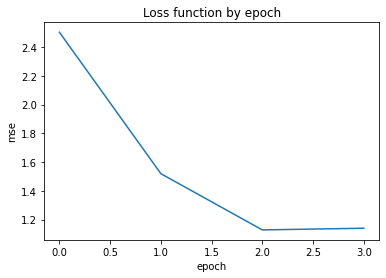

In [11]:
plt.plot(history.history["loss"])
plt.title("Loss function by epoch")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

학습된 모델의 성능 검증을 위하여 결정계수를 구합니다.

In [12]:
pred_y = model.predict(x_test)
y_test = y_test.reshape(-1,1)
evaluate = R_squared(pred_y, y_test) # 결정계수
evaluate

OperatorNotAllowedInGraphError: in user code:

    C:\Users\park\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    <ipython-input-5-7ffa90c42de0>:9 call  *
        input_A, input_B = inputs
    C:\Users\park\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:505 __iter__
        self._disallow_iteration()
    C:\Users\park\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:498 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    C:\Users\park\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:476 _disallow_when_autograph_enabled
        " indicate you are trying to use an unsupported feature.".format(task))

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.
